<h1>Lab : simplified JPEG encoder/decoder</h1>

**Read the guidance**

**Read the topic (.pdf file) first**

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some useful functions:** 
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

**You can directly go to Section 3 and code there**

**Import the libs**

In [303]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: optional (since there will be a quite easy 'manual' way for doing that)
*   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.** 





In [304]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output
    

def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered, 
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    symbols = 0
    for i in range(len(data)):
        if data[i] == symbol:
            symbols += 1
        else:
            if symbols > 0:
                out.append(escape)
                out.append(symbols)
                out.append(data[i])
                symbols = 0
            else:
                out.append(data[i])
    if symbols > 0:
        out.append(escape)
        out.append(symbols)
    return np.array(out)


def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = {}
    #freq should be a dictionary with data as key and frequency as value
    for i in data:
        if i in freq:
            freq[i] += 1
        else:
            freq[i] = 1
    return freq

    
#testing 
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'

rle = {1,5,6,257,61}

output = {1:1,5:1,5:1,0:61}


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [305]:
def compute_huffman_tree(data:list, freq:dict=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))
    
    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]
        
        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [306]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)
    
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [307]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(data)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)



Test 1
{'a': '000', 'e': '001', 't': '0100', 'h': '0101', 'i': '0110', 's': '0111', 'n': '1000', 'm': '1001', 'x': '10100', 'p': '10101', 'l': '10110', 'o': '10111', 'u': '11000', 'r': '11001', 'f': '1101', ' ': '111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1000111110101011011010001
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [308]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print(out)


[[ 1.  5.  3.  2.  9. 10.  4.  9.]
 [ 9.  3.  8.  4.  2.  5.  2.  2.]
 [ 7.  8.  1.  7.  4.  7.  5.  2.]
 [ 8.  9.  1.  8.  4.  3.  2.  4.]
 [ 0.  6.  0.  5.  5.  0.  2.  4.]
 [ 7.  5.  4.  9. 10.  6.  6.  9.]
 [ 4.  1.  7.  0.  7.  9.  3.  7.]
 [ 1.  9.  5.  2.  9.  8.  8.  1.]]
[ 1.  5.  9.  7.  3.  3.  2.  8.  8.  8.  0.  9.  1.  4.  9. 10.  2.  7.
  1.  6.  7.  4.  5.  0.  8.  4.  5.  4.  9.  2.  7.  4.  5.  4.  1.  1.
  9.  7.  9.  5.  3.  5.  2.  2.  2.  0. 10.  0.  5.  2.  7.  6.  2.  4.
  4.  6.  9.  9.  8.  3.  9.  7.  8.  1.]


(256, 256) RGB None 0 255


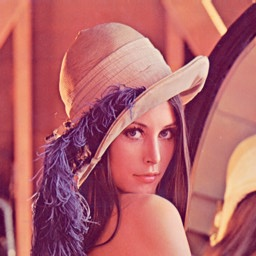

In [309]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
show(imgOriginal)




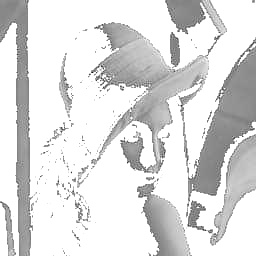

In [310]:

from operator import add
from functools import reduce
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)



def makenxnblocks(img, n=8):
    """
    Splits an image into n x n blocks.
    
    Args:
    - img: A NumPy array that represents an image.
    - n: An integer that specifies the block size.
    
    Returns:
    - blocks: A list of NumPy arrays that represents the blocks of the input image.
    """
    blocks = []
    for i in range(0, img.shape[0], n):
        for j in range(0, img.shape[1], n):
            blocks.append(img[i:i+n, j:j+n])
    return blocks




def centering(blocks):
    """
    Center the values of the pixels in a list of image blocks

    Args:
        blocks: a list of numpy arrays representing image blocks

    Returns:
        A numpy array with the same shape as the input, but with pixel values centered around 0
    """
    centered = []
    for block in blocks:
        centered.append(block - 128)
    return np.array(centered)





def floatify(block):
    """
    Converts the data type of a NumPy array to float.
    
    Args:
    - block: A NumPy array that represents a block.
    
    Returns:
    - A NumPy array that represents the block with float data type.
    """
    return block.astype(float)


def DCT(block):
    """
    Computes the Discrete Cosine Transform (DCT) of a block.
    
    Args:
    - block: A NumPy array that represents a block.
    
    Returns:
    - A NumPy array that represents the DCT coefficients of the block.
    """
    return np.array(cv2.dct(floatify(block)))




def quantization(block, flag="RGB"):
    """
    Applies quantization to a block by dividing the 
    DCT coefficients by the quantization table.
    
    Args:
    - block: A NumPy array that represents a block.
    - flag: A string that specifies the quantization table to use.
    Default is "RGB".
    
    Returns:
    - A NumPy array that represents the quantized block.
    """
    if flag == "RGB":
        return np.round(block/qY)
    else:
        return np.round(block/qC)







def pipeline(img):
    """
    Compresses an image using a pipeline of functions.
    
    Args:
    - img: A NumPy array that represents an image.
    
    Returns:
    - A dictionary that contains the encoded data and the Huffman tables.
    """
    blocks = makenxnblocks(img)
    centered = [centering(block) for block in blocks]
    afterDCT= [DCT(block) for block in centered]
    quantized = [quantization(block) for block in afterDCT]
    zigzagged = [zigzag(block) for block in quantized]
    rlencoded = [rlencode(elem) for elem in zigzagged]
    encoded = [encode_huffman(block,construct_huffman_table(block)) for block in rlencoded]
    tables = [construct_huffman_table(block) for block in rlencoded]
    return {"encoded":encoded, "tables":tables}







def decode_pipeline(dict):
    """
    Decodes the image using huffman decoding and returns the decoded image as a list of numpy arrays.

    Args:
        dict (dict): A dictionary containing the encoded image and the huffman tables.

    Returns:
        list: A list of numpy arrays representing the decoded image.
    """
    decoded = []
    for i in range(len(dict["encoded"])):
        decoded.append(np.array(decode_huffman(dict["encoded"][i],dict["tables"][i]).tolist()))
    return decoded



def intify(matrix):
    """
    Converts all the elements of a numpy array to integers.

    Args:
        matrix (numpy.ndarray): A numpy array.

    Returns:
        numpy.ndarray: A numpy array with all the elements as integers.
    """
    return matrix.astype(int)



def rldecode(vrlc):
    """
    Decodes a run-length encoded array and returns the flattened 1D array.

    Args:
        vrlc (numpy.ndarray): A numpy array representing the run-length encoded image.

    Returns:
        numpy.ndarray: A flattened 1D numpy array representing the decoded image.
    """
    decoded = np.array([])
    for i in range(len(vrlc)):
        if vrlc[i] == 257:
            decoded=np.append(decoded,np.array([0] * vrlc[i+1]))
        if vrlc[i-1]!=257 and vrlc[i]!=257:
            decoded=np.append(decoded,vrlc[i])
            
    return decoded






def inverse_zigzag(block):
    """
    Reverses the zigzag pattern and returns the resulting numpy array.

    Args:
        block (numpy.ndarray): A numpy array representing a single block.

    Returns:
        numpy.ndarray: A numpy array representing the block with the zigzag pattern reversed.
    """
    n = int(np.sqrt(len(block)))
    matrix = np.zeros((n,n))
    i = 0
    j = 0
    for k in range(len(block)):
        matrix[i][j] = block[k]
        if (i+j)%2 == 0:
            if j<n-1:
                j+=1
            else:
                i+=1
            if i>0:
                i-=1
        else:
            if i<n-1:
                i+=1
            else:
                j+=1
            if j>0:
                j-=1
    return intify(matrix)



def inverse_quantization(block, flag="RGB"):
    """
    Applies the inverse quantization to the given block, depending on the specified flag.

    Args:
        block (numpy.ndarray): A numpy array representing a single block.
        flag (str, optional): A flag indicating whether the block represents an RGB or a YCbCr image. Defaults to "RGB".

    Returns:
        numpy.ndarray: A numpy array representing the block after applying the inverse quantization.
    """
    if flag == "RGB":
        return np.multiply(block,qY)
    else:
        return np.multiply(block,qC)





def inverse_DCT(block):
    """
    Applies the inverse Discrete Cosine Transform to the given block.

    Args:
        block (numpy.ndarray): A numpy array representing a single block.

    Returns:
        numpy.ndarray: A numpy array representing the block after applying the inverse DCT.
    """
    return cv2.idct(floatify(block))




def inverse_centering(block):
    """
    Function that receives a block and return the inverse centering of that block.
    Parameters:
        - block: numpy array. Block to apply inverse centering.
    Returns:
        - numpy array. Block with inverse centering applied.
    """
    return block+128





def inverse_makenxnblocks(blocks):
    """
    Function that do the exact opposite of makenxnblocks and returns a original squared image.
    Parameters:
        - blocks: list of numpy arrays. List with blocks to construct the original image.
    Returns:
        - numpy array. Original squared image.
    """
    n = int(np.sqrt(len(blocks)))
    matrix = np.zeros((n*8,n*8))
    for i in range(n):
        for j in range(n):
            matrix[i*8:i*8+8,j*8:j*8+8] = blocks[i*n+j]
    return matrix





def inverse_pipeline(dict):
    """
    Function that receives a dictionary and return the original image.
    Parameters:
        - dict: dictionary. Dictionary with encoded image and tables.
    Returns:
        - numpy array. Original image.
    """
    decoded = [intify(elem) for elem in decode_pipeline(dict)]
    rldecoded_blocks = [rldecode(elem) for elem in decoded]
    inverse_zigzag_blocks = [inverse_zigzag(block) for block in rldecoded_blocks]
    inverse_quantization_blocks = [inverse_quantization(block) for block in inverse_zigzag_blocks]
    inverse_DCT_blocks = [inverse_DCT(block) for block in inverse_quantization_blocks]
    inverse_centering_blocks = [inverse_centering(block) for block in inverse_DCT_blocks]
    return inverse_makenxnblocks(inverse_centering_blocks)




transmitted = pipeline(img)
recovered_image = inverse_pipeline(transmitted)
imshow(recovered_image)



256 256 3


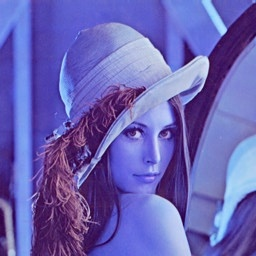

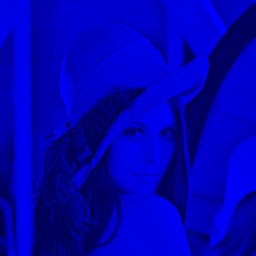

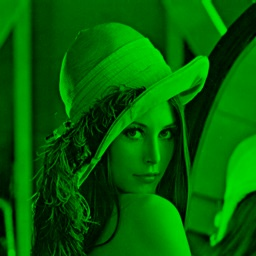

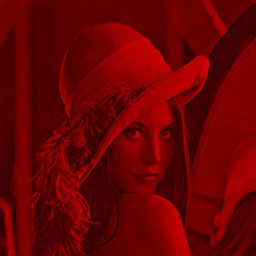

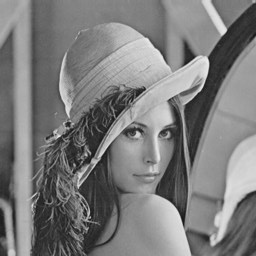

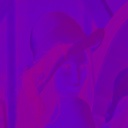

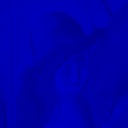

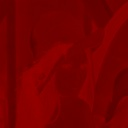

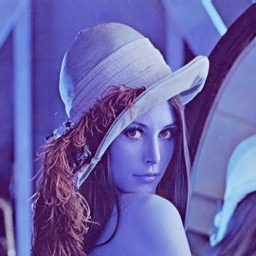

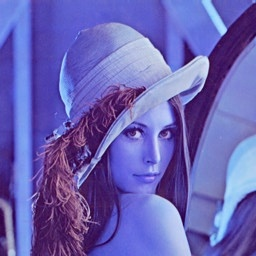

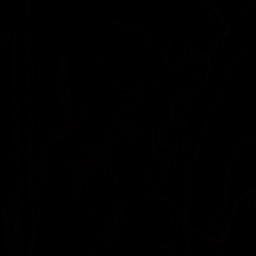

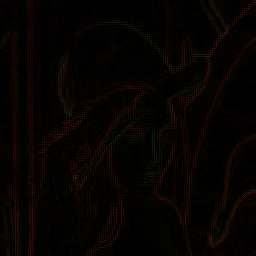

In [311]:

img=imgOriginal.copy()
print(len(img[:,0,0]),len(img[0,:,0]),len(img[0,0,:]))

R=img[:,:,0]
G=img[:,:,1]
B=img[:,:,2]

Y=0.299*R+0.587*G+0.114*B
Cb=-0.1687*R-0.3313*G+0.5*B+128
Cr=0.5*R-0.4187*G-0.0813*B+128


def mean_in_2x2(image):
    x = int(len(image[:,0])/2) #  x=M/2
    y = int(len(image[0,:])/2) #  y=N/2
    blocks = np.zeros((x,y))   # New array x*y
    for i in range(0,x,1):
        for j in range(0,y,1): # Take blocks of size 2x2
            block = np.array(image[2*i:2*i+2, 2*j:2*j+2]) 
            block = np.mean(block) # Compute the mean 
            blocks[i,j]=block # Assing the mean to the new array 
    return np.array(blocks) 
 
Cr=mean_in_2x2(Cr) 
Cb=mean_in_2x2(Cb) 

#Plotting 
# Original components 
imshow(img) # Original image
imshow(np.dstack((R,np.zeros((len(R[:,0]),len(R[0,:]))),np.zeros((len(R[:,0]),len(R[0,:]))))))
imshow(np.dstack((np.zeros((len(G[:,0]),len(G[0,:]))),G,np.zeros((len(G[:,0]),len(R[0,:]))))))
imshow(np.dstack((np.zeros((len(B[:,0]),len(B[0,:]))),np.zeros((len(B[:,0]),len(R[0,:]))),B)))

# Luminance/Chrominance
imshow(Y) 
rgb = np.dstack((Cr,np.zeros((len(Cr[:,0]),len(Cr[0,:]))),Cb))  
imshow(rgb)
rgb_b = np.dstack((Cr,np.zeros((len(Cr[:,0]),len(Cr[0,:]))),np.zeros((len(Cr[:,0]),len(Cr[0,:])))))
imshow(rgb_b)
rgb_r = np.dstack((np.zeros((len(Cr[:,0]),len(Cr[0,:]))),np.zeros((len(Cr[:,0]),len(Cr[0,:]))),Cb)) 
imshow(rgb_r)

def Add_twice(image):
    blocks = np.zeros((2*len(image[:,0]),2*len(image[0,:])))
    for i in range(0,len(image),1):
        for j in range(0,len(image),1):
            blocks[2*i:2*i+2, 2*j:2*j+2]=image[i,j]
    return np.array(blocks) 

Cr_n=Add_twice(Cr)
Cb_n=Add_twice(Cb)

R=Y+1.14020*(Cr_n-128);
G=Y-0.34414*(Cb_n-128)-0.71414*(Cr_n-128)
B=Y+1.77200*(Cb_n-128)

rgb= np.dstack((R,G,B)) 
imshow(rgb)

imshow(img)
imshow((rgb-img))
imshow((rgb-img)*10)


In [312]:



def grayscale_pipeline(image):
    """
    Function that receives a grayscale image and return the original image.
    Parameters:
        - image: numpy array. Grayscale image.
    Returns:
        - numpy array. Original image.
    """
    transmitted = pipeline(image)
    recovered_image = inverse_pipeline(transmitted)
    return recovered_image

def RGB_pipeline(image):
    """
    Function that receives a 3 channel RGB image and return the original image.
    Parameters:
        - image: numpy array. 3 channel RGB image.
    Returns:
        - numpy array. Original image.
    """
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    r_transmitted = pipeline(r)
    g_transmitted = pipeline(g)
    b_transmitted = pipeline(b)
    r_recovered_image = inverse_pipeline(r_transmitted)
    g_recovered_image = inverse_pipeline(g_transmitted)
    b_recovered_image = inverse_pipeline(b_transmitted)
    recovered_image = np.zeros((r_recovered_image.shape[0],r_recovered_image.shape[1],3))
    recovered_image[:,:,0] = r_recovered_image
    recovered_image[:,:,1] = g_recovered_image
    recovered_image[:,:,2] = b_recovered_image
    return recovered_image




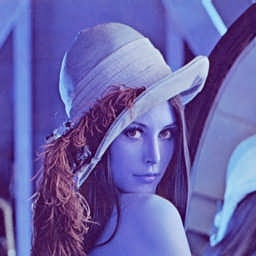

In [313]:
def chrominance_pipeline(img, downsampling=False):
    """
    Function that receives a 3 channel RGB image and return the original image.
    Parameters:
        - image: numpy array. 3 channel RGB image.
    Returns:
        - numpy array. Original image.
    """


    R=img[:,:,0]
    G=img[:,:,1]
    B=img[:,:,2]

    Y=0.299*R+0.587*G+0.114*B
    Cb=-0.1687*R-0.3313*G+0.5*B+128
    Cr=0.5*R-0.4187*G-0.0813*B+128
   
    
    Cb_image = np.zeros((len(img), len(img), 3))
    Cb_image[:, :, 2] = Cb
    Cr_image = np.zeros((len(img), len(img), 3))
    Cr_image[:, :, 0] = Cr


    if downsampling:
        Cr=mean_in_2x2(Cr) 
        Cb=mean_in_2x2(Cb) 
    else:
        pass
        

    y_transmitted = pipeline(Y)
    cb_transmitted = pipeline(Cb)
    cr_transmitted = pipeline(Cr)
    y_recovered_image = inverse_pipeline(y_transmitted)
    cb_recovered_image = inverse_pipeline(cb_transmitted)
    cr_recovered_image = inverse_pipeline(cr_transmitted)


    if downsampling:
        cr_recovered_image=Add_twice(Cr)
        cb_recovered_image=Add_twice(Cb)
    else:
        pass
        

    R_final=y_recovered_image+1.14020*(cr_recovered_image-128);
    G_final=y_recovered_image-0.34414*(cb_recovered_image-128)-0.71414*(cr_recovered_image-128)
    B_final=y_recovered_image+1.77200*(cb_recovered_image-128)

    rgb= np.dstack((R_final,G_final,B_final))
    return rgb



        

   

imshow(chrominance_pipeline(img,downsampling=True))


**Different Pipelines results**

***Original Image***


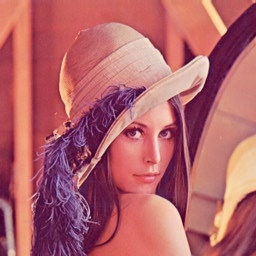

In [338]:
imgOriginal = cv2.imread('lena.jpg')
imshow(imgOriginal)


#define compression ratio(original_image,output)
def compression_ratio(original_image,compressed_image):

    #Size of images in bytes
    orig_size = np.size(original_image)
    comp_size = np.size(compressed_image)
    compression_ratio = orig_size / comp_size

    print("Compression ratio: ",compression_ratio)

    return compression_ratio


def errors(original_image,compressed_image):
    # Calculate the difference between the original and the compressed image
    error_image = original_image - compressed_image

    # Calculate the mean squared error (MSE)
    mse = np.mean(np.square(error_image))

    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(mse)
    return mse,rmse,error_image


def error_image(original_image,compressed_image):
    # Calculate the difference between the original and the compressed image
    error_image = original_image - compressed_image
    imshow(error_image)


def psnr(orignal_image, compressed_image):
    mse,rmse,ei = errors(orignal_image, compressed_image)
    psnr = 20 * np.log10(255 / rmse)
    print("MSE: ",mse)
    print("RMSE: ",rmse)

    print("PSNR: ",psnr)


**Grayscale Pipeline**

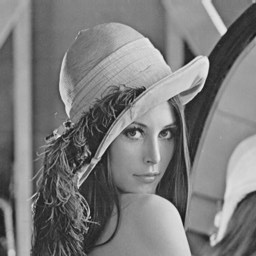

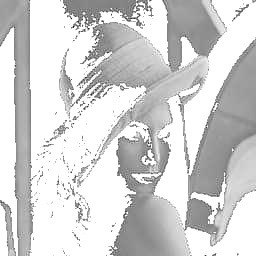

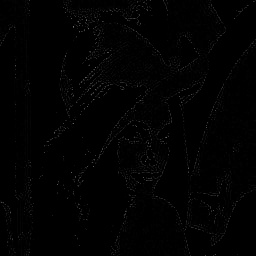

Compression ratio:  1.0
MSE:  31536.65141433868
RMSE:  177.58561713815305
PSNR:  3.1426478314579445


In [339]:
grayscale_image = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
imshow(grayscale_image)
imshow(grayscale_pipeline(grayscale_image))

error_image(grayscale_image,grayscale_pipeline(grayscale_image))
compression_ratio(grayscale_image,grayscale_pipeline(grayscale_image))
errors(grayscale_image,grayscale_pipeline(grayscale_image))
psnr(grayscale_image,grayscale_pipeline(grayscale_image))


**RGB Pipeline**

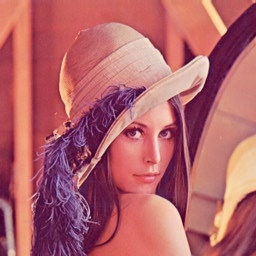

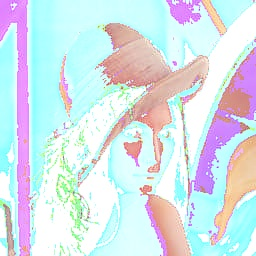

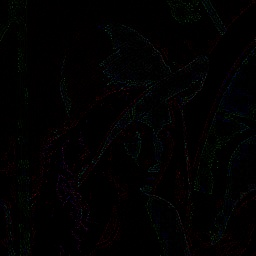

Compression ratio:  1.0
MSE:  36186.9229571594
RMSE:  190.22860709462023
PSNR:  2.5452870507500593


In [340]:

imshow(imgOriginal)
imshow(RGB_pipeline(imgOriginal))


error_image(imgOriginal,RGB_pipeline(imgOriginal))
compression_ratio(imgOriginal,RGB_pipeline(imgOriginal))
errors(imgOriginal,RGB_pipeline(imgOriginal))
psnr(imgOriginal,RGB_pipeline(imgOriginal))

**Chrominance without downsampling Pipeline**

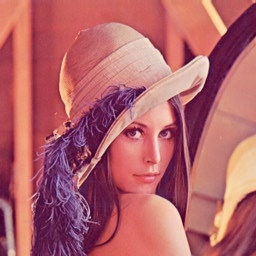

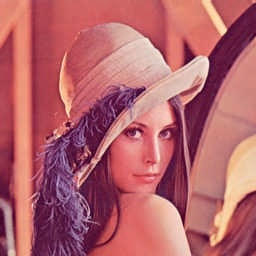

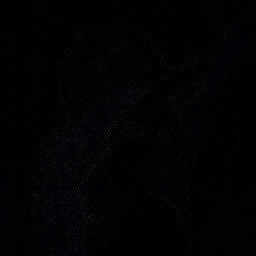

Compression ratio:  1.0
MSE:  34.9731038402405
RMSE:  5.913806205840745
PSNR:  32.693461834951485


In [341]:
imshow(imgOriginal)
imshow(chrominance_pipeline(imgOriginal))

error_image(imgOriginal,chrominance_pipeline(imgOriginal))
compression_ratio(imgOriginal,chrominance_pipeline(imgOriginal))
errors(imgOriginal,chrominance_pipeline(imgOriginal))
psnr(imgOriginal,chrominance_pipeline(imgOriginal))

**Chrominance with downsampling Pipeline**

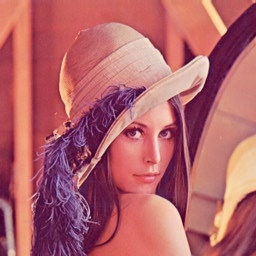

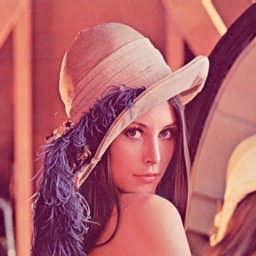

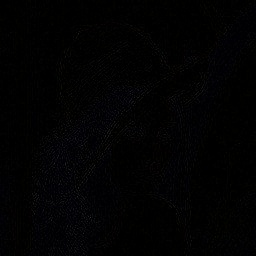

Compression ratio:  1.0
MSE:  34.217145502777996
RMSE:  5.849542332762281
PSNR:  32.78836584303978


In [342]:
imshow(imgOriginal)
imshow(chrominance_pipeline(imgOriginal, downsampling=True))

error_image(imgOriginal,chrominance_pipeline(imgOriginal, downsampling=True))
compression_ratio(imgOriginal,chrominance_pipeline(imgOriginal, downsampling=True))
errors(imgOriginal,chrominance_pipeline(imgOriginal, downsampling=True))
psnr(imgOriginal,chrominance_pipeline(imgOriginal, downsampling=True))
